# Description

Generates the figure for top cell types for a specified LV (in Settings section below).

# Modules loading

In [1]:
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from data.recount2 import LVAnalysis
from utils import chunker
import conf

# Settings

In [2]:
LV_NAME = "LV383"

In [69]:
LV_AXIS_THRESHOLD = 1.5 # 3.0
# LV_AXIS_THRESHOLD = 2.0
N_TOP_SAMPLES = 400
N_TOP_ATTRS = 15

In [10]:
# OUTPUT_FIGURES_DIR = Path(
#     conf.MANUSCRIPT["FIGURES_DIR"], "lvs_analysis", f"{LV_NAME.lower()}"
# ).resolve()
# display(OUTPUT_FIGURES_DIR)
# OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

In [11]:
# OUTPUT_CELL_TYPE_FILEPATH = OUTPUT_FIGURES_DIR / f"{LV_NAME.lower()}-cell_types.svg"
# display(OUTPUT_CELL_TYPE_FILEPATH)

# Load MultiPLIER summary

In [12]:
multiplier_model_summary = pd.read_pickle(conf.MULTIPLIER["MODEL_SUMMARY_FILE"])

In [13]:
multiplier_model_summary.shape

(2157, 5)

In [14]:
multiplier_model_summary.head()

,pathway,LV index,AUC,p-value,FDR
1,KEGG_LYSINE_DEGRADATION,1,0.388059,0.866078,0.956005
2,REACTOME_MRNA_SPLICING,1,0.733057,0.000048,0.000582
3,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,1,0.680555,0.001628,0.011366
4,KEGG_DNA_REPLICATION,1,0.549473,0.312155,0.539951
5,PID_MYC_ACTIVPATHWAY,1,0.639303,0.021702,0.083739


# Load data

## Original data

In [15]:
# INPUT_SUBSET = "z_score_std"

In [16]:
# INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [17]:
# input_filepath = Path(
#     conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
#     INPUT_SUBSET,
#     f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
# ).resolve()
# display(input_filepath)

# assert input_filepath.exists(), "Input file does not exist"

# input_filepath_stem = input_filepath.stem
# display(input_filepath_stem)

In [18]:
# data = pd.read_pickle(input_filepath)

In [19]:
# data.shape

In [20]:
# data.head()

## LV data

In [21]:
# lv_obj = LVAnalysis(LV_NAME, data)
lv_obj = LVAnalysis(LV_NAME)

In [22]:
multiplier_model_summary[
    multiplier_model_summary["LV index"].isin((LV_NAME[2:],))
    & (
        (multiplier_model_summary["FDR"] < 0.05)
        | (multiplier_model_summary["AUC"] >= 0.75)
    )
]

,pathway,LV index,AUC,p-value,FDR


In [23]:
lv_data = lv_obj.get_experiments_data()

SRP042161, SRP060416, SRP055569, SRP066834, SRP057196, SRP010279, SRP009862, SRP033135, SRP042620, SRP055153, SRP059775, SRP058773, SRP058667, SRP002326, SRP050499, SRP026537, SRP050992, SRP009266, SRP064464, SRP064259, SRP002184, SRP045659, SRP055444, SRP062025, SRP012461, SRP050892, SRP034712, SRP059379, SRP063840, SRP011578, SRP060355, SRP049820, SRP006474, SRP044042, SRP030617, 

/opt/code/libs/data/recount2.py:360: UserWarning: Not all experiments data could be loaded (33 != 35)
  warnings.warn(


In [24]:
lv_data.shape

(6606, 73)

In [25]:
lv_data.head()

cell line     cell type patient id subtype tonsil donor  \
project   run                                                                  
SRP042161 SRR1294536       NaN  Glioblastoma      MGH26     NaN          NaN   
          SRR1294537       NaN  Glioblastoma      MGH26    None          NaN   
          SRR1294538       NaN  Glioblastoma      MGH26     NaN          NaN   
          SRR1294539       NaN  Glioblastoma      MGH26     NaN          NaN   
          SRR1294540       NaN  Glioblastoma      MGH26     NaN          NaN   

                     facs gating Stage tissue  age c1 chip id  ...  \
project   run                                                  ...   
SRP042161 SRR1294536         NaN   NaN    NaN  NaN        NaN  ...   
          SRR1294537         NaN   NaN    NaN  NaN        NaN  ...   
          SRR1294538         NaN   NaN    NaN  NaN        NaN  ...   
          SRR1294539         NaN   NaN    NaN  NaN        NaN  ...   
          SRR1294540         NaN   NaN    NaN  NaN        NaN  ...   

                     culture positive clip variant enzymatic digestion  \
project   run                                                            
SRP042161 SRR1294536              NaN          NaN                 NaN   
          SRR1294537              NaN          NaN                 NaN   
          SRR1294538              NaN          NaN                 NaN   
          SRR1294539              NaN          NaN                 NaN   
          SRR1294540              NaN          NaN                 NaN   

                     protein sample type pretreatment grade  \
project   run                                                 
SRP042161 SRR1294536     NaN         NaN          NaN   NaN   
          SRR1294537     NaN         NaN          NaN   NaN   
          SRR1294538     NaN         NaN          NaN   NaN   
          SRR1294539     NaN         NaN          NaN   NaN   
          SRR1294540     NaN         NaN          NaN   NaN   

                     cdna synthesis method library construction method  \
project   run                                                            
SRP042161 SRR1294536                   NaN                         NaN   
          SRR1294537                   NaN                         NaN   
          SRR1294538                   NaN                         NaN   
          SRR1294539                   NaN                         NaN   
          SRR1294540                   NaN                         NaN   

                         LV383  
project   run                   
SRP042161 SRR1294536  0.027922  
          SRR1294537 -0.028572  
          SRR1294538 -0.008107  
          SRR1294539 -0.027338  
          SRR1294540  0.056674  

[5 rows x 73 columns]

# LV cell types analysis

## Get top attributes

In [26]:
lv_attrs = lv_obj.get_attributes_variation_score()
display(lv_attrs.head(20))

cell line                 0.106848
cell type                 0.022345
antibody                  0.008353
antibody catalog #        0.008353
antibody lot #            0.008353
antibody manufacturer     0.008353
tissue type               0.007450
tag                       0.007450
tissue subtype            0.007450
tonsil donor              0.006804
facs gating               0.006804
age                       0.005241
c1 chip id                0.005241
experiment_sample_name    0.005241
infection                 0.004385
shRNA treatment           0.004385
Stage                     0.003896
biological replicate      0.003604
tissue                    0.003398
knockdown                 0.002570
dtype: float64

In [27]:
# show those with cell type or tissue in their name
_tmp = pd.Series(lv_attrs.index)
lv_attrs[
    _tmp.str.match(
        "(?:cell.+type$)|(?:tissue$)|(?:tissue.+type$)",
        case=False,
        flags=re.IGNORECASE,
    ).values
].sort_values(ascending=False)

cell type         0.022345
tissue type       0.007450
tissue subtype    0.007450
tissue            0.003398
cell phenotype    0.000329
dtype: float64

In [28]:
_tmp = lv_data.loc[
    :,
    [
        # "cell line",
        "cell type",
        "tissue type",
        "tissue",
        # "tissue subtype",
        # "tissue type",
        LV_NAME,
    ],
]

In [29]:
_tmp_seq = list(chunker(_tmp.sort_values(LV_NAME, ascending=False), 25))

In [35]:
_tmp_seq[2]

cell type  \
project   run                                                             
SRP066834 SRR2967413                                                NaN   
SRP057196 SRR1975008                                    fetal_quiescent   
          SRR1974560                                             hybrid   
SRP042161 SRR1295028                                       Glioblastoma   
SRP057196 SRR1974663                                            neurons   
SRP066834 SRR2967632                                                NaN   
SRP042161 SRR1295065                                       Glioblastoma   
SRP066834 SRR2967786                                                NaN   
SRP060416 SRR2088128                       tonsil Innate lymphoid cells   
SRP042161 SRR1295038                                       Glioblastoma   
SRP060416 SRR2088182                       tonsil Innate lymphoid cells   
SRP055569 SRR1821564  mixture of U87 human glioma cells and MCF10a h...   
SRP042161 SRR1295083                                       Glioblastoma   
SRP066834 SRR2967354                                                NaN   
          SRR2967433                                                NaN   
SRP060416 SRR2088389                       tonsil Innate lymphoid cells   
SRP066834 SRR2967332                                                NaN   
          SRR2967625                                                NaN   
SRP057196 SRR1974601                                             hybrid   
          SRR1974567                                             hybrid   
          SRR1974843                                            neurons   
SRP060416 SRR2088607                       tonsil Innate lymphoid cells   
SRP033135 SRR1033274             Human Skeletal Muscle Myoblasts (HSMM)   
SRP057196 SRR1974628                                            neurons   
SRP042161 SRR1294617                                       Glioblastoma   

                     tissue type  \
project   run                      
SRP066834 SRR2967413         NaN   
SRP057196 SRR1975008         NaN   
          SRR1974560         NaN   
SRP042161 SRR1295028         NaN   
SRP057196 SRR1974663         NaN   
SRP066834 SRR2967632         NaN   
SRP042161 SRR1295065         NaN   
SRP066834 SRR2967786         NaN   
SRP060416 SRR2088128         NaN   
SRP042161 SRR1295038         NaN   
SRP060416 SRR2088182         NaN   
SRP055569 SRR1821564         NaN   
SRP042161 SRR1295083         NaN   
SRP066834 SRR2967354         NaN   
          SRR2967433         NaN   
SRP060416 SRR2088389         NaN   
SRP066834 SRR2967332         NaN   
          SRR2967625         NaN   
SRP057196 SRR1974601         NaN   
          SRR1974567         NaN   
          SRR1974843         NaN   
SRP060416 SRR2088607         NaN   
SRP033135 SRR1033274         NaN   
SRP057196 SRR1974628         NaN   
SRP042161 SRR1294617         NaN   

                                                                 tissue  \
project   run                                                             
SRP066834 SRR2967413                Dissociated whole cerebral organoid   
SRP057196 SRR1975008                                             cortex   
          SRR1974560                                             cortex   
SRP042161 SRR1295028                                                NaN   
SRP057196 SRR1974663                                             cortex   
SRP066834 SRR2967632                                    Fetal neocortex   
SRP042161 SRR1295065                                                NaN   
SRP066834 SRR2967786                                    Fetal neocortex   
SRP060416 SRR2088128                                                NaN   
SRP042161 SRR1295038                                                NaN   
SRP060416 SRR2088182                                                NaN   
SRP055569 SRR1821564                                                NaN   
SRP042161 SRR

In [31]:
# # what is there in these projects?
# lv_data.loc[["SRP011422"]].dropna(how="all", axis=1).sort_values(
#     LV_NAME, ascending=False
# ).sort_values(LV_NAME, ascending=False).head(10)

In [36]:
SELECTED_ATTRIBUTE = "cell type"

In [37]:
# it has to be in the order desired for filling nans in the SELECTED_ATTRIBUTE
SECOND_ATTRIBUTES = ["tissue"]

## Get plot data

In [70]:
plot_data = lv_data.loc[:, [SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES + [LV_NAME]]

In [71]:
# if blank/nan, fill cell type column with tissue content
_new_column = plot_data[[SELECTED_ATTRIBUTE] + SECOND_ATTRIBUTES].fillna(
    method="backfill", axis=1
)[SELECTED_ATTRIBUTE]
plot_data[SELECTED_ATTRIBUTE] = _new_column
plot_data = plot_data.drop(columns=SECOND_ATTRIBUTES)
plot_data = plot_data.fillna({SELECTED_ATTRIBUTE: "NOT CATEGORIZED"})
# plot_data = plot_data.dropna(subset=[SELECTED_ATTRIBUTE])

In [72]:
plot_data = plot_data.sort_values(LV_NAME, ascending=False)

In [73]:
plot_data.head(20)

cell type  \
project   run                                                             
SRP042161 SRR1295300                             Gliomasphere Cell Line   
SRP060416 SRR2088233                       tonsil Innate lymphoid cells   
SRP055569 SRR1821380                             U87 human glioma cells   
          SRR1821639                   MCF10a human breast cancer cells   
SRP066834 SRR2967407                Dissociated whole cerebral organoid   
SRP060416 SRR2088178                       tonsil Innate lymphoid cells   
          SRR2088174                       tonsil Innate lymphoid cells   
SRP055569 SRR1821706                   MCF10a human breast cancer cells   
SRP060416 SRR2088176                       tonsil Innate lymphoid cells   
SRP057196 SRR1974947                                    fetal_quiescent   
SRP055569 SRR1821614  mixture of U87 human glioma cells and MCF10a h...   
SRP060416 SRR2088236                       tonsil Innate lymphoid cells   
SRP042161 SRR1295026                                       Glioblastoma   
SRP060416 SRR2088095                       tonsil Innate lymphoid cells   
SRP066834 SRR2967501  Microdissected cortical-like ventricle from ce...   
SRP055569 SRR1821397                             U87 human glioma cells   
SRP057196 SRR1974707                                            neurons   
          SRR1974765                                   oligodendrocytes   
SRP010279 SRR398198                                     NOT CATEGORIZED   
SRP066834 SRR2967691                                    Fetal neocortex   

                         LV383  
project   run                   
SRP042161 SRR1295300  9.129459  
SRP060416 SRR2088233  0.996977  
SRP055569 SRR1821380  0.816448  
          SRR1821639  0.663602  
SRP066834 SRR2967407  0.651403  
SRP060416 SRR2088178  0.592799  
          SRR2088174  0.579221  
SRP055569 SRR1821706  0.510121  
SRP060416 SRR2088176  0.493631  
SRP057196 SRR1974947  0.461413  
SRP055569 SRR1821614  0.424233  
SRP060416 SRR2088236  0.415974  
SRP042161 SRR1295026  0.409717  
SRP060416 SRR2088095  0.407959  
SRP066834 SRR2967501  0.395114  
SRP055569 SRR1821397  0.391422  
SRP057196 SRR1974707  0.388492  
          SRR1974765  0.386011  
SRP010279 SRR398198   0.360195  
SRP066834 SRR2967691  0.355369

## Customize x-axis values

When cell type values are not very clear, customize their names by looking at their specific studies to know exactly what the authors meant.

In [74]:
final_plot_data = plot_data.replace(
    {
        SELECTED_ATTRIBUTE: {
            # "human bone marrow sample": "bone marrow",
            "whole blood": "Whole blood",
            # "peripheral blood": "Peripheral blood",
            # "peripheral whole blood": "Peripheral blood",
            # "breast cancer": "Breast cancer",
            # "breast cancer cell line": "Breast cancer",
            # SRP057196
            # "fetal_replicating": "Fetal neurons (replicating)",
            # "fetal_quiescent": "Fetal neurons (quiescent)",
            # "normal skin": "Skin",
            # "liver": "Liver",
            # "Human Skeletal Muscle Myoblasts (HSMM)": "Skeletal muscle myoblasts",
            # "astrocytes": "Astrocytes",
            "mixture of U87 human glioma cells and MCF10a human breast cancer cells": "Glioma + MCF10 breast cancer cells",
            "mixture of U87 human glioma cells and WI-38 human lung fibroblast cells": "Glioma + WI-38 lung fibroblast cells",
            # "functional hepatocytes generated by lineage reprogramming": "Hepatocytes",
            # "human adipose-derived stem cells": "Adipose-derived stem cells",
            # "adipose": "Adipose",
            # "embryonic stem cells": "Embryonic stem cells",
            # "primary keratinocytes": "Primary keratinocytes",
            # "fetal liver": "Fetal liver",
            # "in vitro differentiated erythroid cells": "Erythroid cells",
            # "WAT": "White adipose tissue",
            # "BAT": "Brown adipose tissue",
            # "Uninvolved Breast Tissue Adjacent to ER+ Primary Tumor": "Breast tissue adjacent to ER+ tumor",
            # "ovarian granulosa cells": "Ovarian granulosa cells",
        }
    }
)

In [75]:
# sorte index to avoid PerformanceWarning from pandas
final_plot_data = final_plot_data.sort_index()

In [76]:
_srp_code = "SRP060416"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: x[SELECTED_ATTRIBUTE]
    + f" ({lv_data.loc[(_srp_code, x.name), 'facs gating']})",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

In [77]:
# _srp_code = "SRP059172"
# _tmp = final_plot_data.loc[(_srp_code,)].apply(
#     lambda x: x[SELECTED_ATTRIBUTE]
#     + f" ({lv_data.loc[(_srp_code, x.name), 'group']})",
#     axis=1,
# )
# final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

In [78]:
# _srp_code = "SRP062966"
# _tmp = final_plot_data.loc[(_srp_code,)].apply(
#     lambda x: x[SELECTED_ATTRIBUTE]
#     + f" ({lv_data.loc[(_srp_code, x.name), 'disease status']})",
#     axis=1,
# )
# final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

In [79]:
_srp_code = "SRP064464"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: f"Pancreatic islets"
    + f" ({lv_data.loc[(_srp_code, x.name), 'assigned cell type']})",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

In [80]:
# _srp_code = "SRP029990" # these cases seem to be the same in SRP032775 and are just a few
# final_plot_data = final_plot_data.drop((_srp_code,))

In [81]:
# _srp_code = "SRP032775" # this one is also about Maralia

# main_attr = "time point"
# second_attrs = ["time-point"]

# def _apply_func(x):
#     return "Whole blood" + f" ({x[main_attr].lower()}, Malaria)"

# _lv_data = lv_data.loc[(_srp_code,), [main_attr] + second_attrs + [LV_NAME]]
# _new_column = _lv_data[[main_attr] + second_attrs].fillna(
#     method="backfill", axis=1
# )[main_attr]
# _lv_data[main_attr] = _new_column
# # _lv_data = _lv_data.drop(columns=second_attrs)

# _tmp = _lv_data.apply(
#     _apply_func,
#     axis=1,
# )
# final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

In [82]:
# _srp_code = "SRP059039"
# _tmp = final_plot_data.loc[(_srp_code,)].apply(
#     lambda x: x[SELECTED_ATTRIBUTE]
#     + f" ({lv_data.loc[(_srp_code, x.name), 'group']} cases)",
#     axis=1,
# )
# final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

In [83]:
# _srp_code = "SRP056443"
# _tmp = final_plot_data.loc[(_srp_code,)].apply(
#     lambda x: x[SELECTED_ATTRIBUTE]
#     + f" ({lv_data.loc[(_srp_code, x.name), 'time']})",
#     axis=1,
# )
# final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

In [84]:
# _srp_code = "SRP056840"
# _tmp = final_plot_data.loc[(_srp_code,)].apply(
#     lambda x: "Whole blood"
#     + f" ({lv_data.loc[(_srp_code, x.name), 'sirs outcomes']})",
#     axis=1,
# )
# final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

In [85]:
# _srp_code = "SRP050000"
# _tmp = final_plot_data.loc[(_srp_code,)].apply(
#     lambda x: "Peripheral blood (SIRS or sepsis)",
#     # + f" ({lv_data.loc[(_srp_code, x.name), 'sirs outcomes']})",
#     axis=1,
# )
# final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

In [86]:
# _srp_code = "SRP045500"
# _tmp = lv_data.loc[(_srp_code,)].apply(
#     lambda x: x["celltype"],
#     # + f" ({lv_data.loc[(_srp_code, x.name), 'sirs outcomes']})",
#     axis=1,
# )
# final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

In [87]:
_srp_code = "SRP057196"
_tmp = lv_data.loc[(_srp_code,)].apply(
    lambda x: x["tissue"]
    + f" ({lv_data.loc[(_srp_code, x.name), 'cell type']})",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

/tmp/ipykernel_746/3922095706.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  _tmp = lv_data.loc[(_srp_code,)].apply(


In [88]:
# _srp_code = "SRP058773"
# _tmp = final_plot_data.loc[(_srp_code,)].apply(
#     lambda x: f"Fibroblasts",
#     axis=1,
# )
# final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

In [89]:
_srp_code = "SRP050499"
_tmp = final_plot_data.loc[(_srp_code,)].apply(
    lambda x: f"Primordial germ cells (PGC)",
    axis=1,
)
final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

In [90]:
# _srp_code = "SRP027015"
# _tmp = final_plot_data.loc[(_srp_code,)].apply(
#     lambda x: "Peripheral blood (MM.1S)",
#     # + f" ({lv_data.loc[(_srp_code, x.name), 'facs gating']})",
#     axis=1,
# )
# final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

In [91]:
# _srp_code = "SRP061329"
# _tmp = final_plot_data.loc[(_srp_code,)].apply(
#     lambda x: "Peripheral blood"
#     + f" ({lv_data.loc[(_srp_code, x.name), 'cell line']})",
#     axis=1,
# )
# final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

In [92]:
# _srp_code = "SRP018838"
# _tmp = final_plot_data.loc[(_srp_code,)].apply(
#     lambda x: "Blood"
#     + f" ({lv_data.loc[(_srp_code, x.name), 'cell line']})",
#     axis=1,
# )
# final_plot_data.loc[(_srp_code, _tmp.index), SELECTED_ATTRIBUTE] = _tmp.values

In [93]:
# # take the top samples only
# final_plot_data = final_plot_data.sort_values(LV_NAME, ascending=False)[:N_TOP_SAMPLES]

## Threshold LV values

In [94]:
if LV_AXIS_THRESHOLD is not None:
    final_plot_data.loc[
        final_plot_data[LV_NAME] > LV_AXIS_THRESHOLD, LV_NAME
    ] = LV_AXIS_THRESHOLD

## Delete samples with no tissue/cell type information

In [95]:
# final_plot_data = final_plot_data[
#     final_plot_data[SELECTED_ATTRIBUTE] != "NOT CATEGORIZED"
# ]

## Set x-axis order

In [96]:
attr_order = (
    final_plot_data.groupby(SELECTED_ATTRIBUTE)
    .max()
    .sort_values(LV_NAME, ascending=False)
    .index[:N_TOP_ATTRS]
    .tolist()
)

In [97]:
len(attr_order)

15

In [98]:
attr_order[:5]

['Gliomasphere Cell Line',
 'tonsil Innate lymphoid cells (NK)',
 'U87 human glioma cells',
 'MCF10a human breast cancer cells',
 'Dissociated whole cerebral organoid']

## Plot

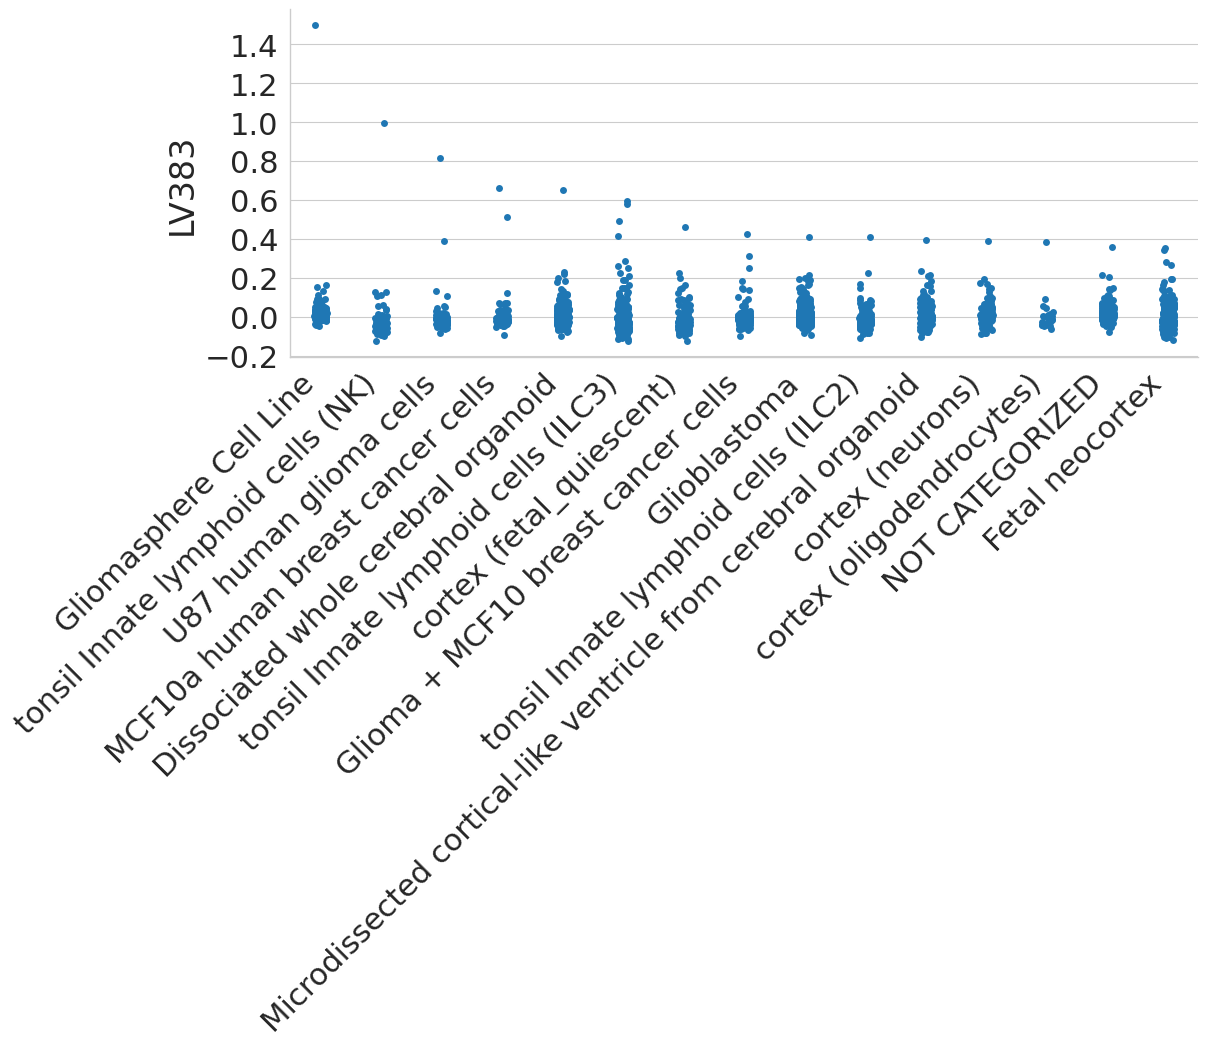

In [99]:
with sns.plotting_context("paper", font_scale=2.5), sns.axes_style("whitegrid"):
    g = sns.catplot(
        data=final_plot_data,
        y=LV_NAME,
        x=SELECTED_ATTRIBUTE,
        order=attr_order,
        kind="strip",
        height=5,
        aspect=2.5,
    )
    plt.xticks(rotation=45, horizontalalignment="right")
    plt.xlabel("")

    # plt.savefig(
    #     OUTPUT_CELL_TYPE_FILEPATH,
    #     bbox_inches="tight",
    #     facecolor="white",
    # )

In [100]:
# with sns.plotting_context("paper", font_scale=2.5), sns.axes_style("whitegrid"):
#     g = sns.catplot(
#         data=final_plot_data,
#         y=LV_NAME,
#         x=SELECTED_ATTRIBUTE,
#         order=attr_order,
#         kind="box",
#         height=5,
#         aspect=2.5,
#     )
#     plt.xticks(rotation=45, horizontalalignment="right")
#     plt.xlabel("")

#     # plt.savefig(
#     #     OUTPUT_CELL_TYPE_FILEPATH,
#     #     bbox_inches="tight",
#     #     facecolor="white",
#     # )

# Debug

In [101]:
with pd.option_context(
    "display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None
):
    _tmp = final_plot_data[final_plot_data[SELECTED_ATTRIBUTE].str.contains("^neurons$")].sort_values(LV_NAME, ascending=False)
    display(_tmp.head(20))

,,cell type,LV383
project,run,,


In [157]:
# what is there in these projects?
_tmp = lv_data.loc[["SRP057196"]].dropna(how="all", axis=1).sort_values(
    LV_NAME, ascending=False
)

display(_tmp.head(60))

cell type       tissue                 age  \
project   run                                                              
SRP057196 SRR1974810            neurons       cortex  postnatal 21 years   
          SRR1974896  fetal_replicating       cortex    prenatal 16-18 W   
          SRR1974888  fetal_replicating       cortex    prenatal 16-18 W   
          SRR1974761        endothelial       cortex  postnatal 63 years   
          SRR1974690   oligodendrocytes       cortex  postnatal 50 years   
          SRR1974999    fetal_quiescent       cortex    prenatal 16-18 W   
          SRR1974720         astrocytes       cortex  postnatal 50 years   
          SRR1974760   oligodendrocytes       cortex  postnatal 63 years   
          SRR1974790   oligodendrocytes  hippocampus  postnatal 63 years   
          SRR1974805   oligodendrocytes       cortex  postnatal 21 years   
          SRR1974957    fetal_quiescent       cortex    prenatal 16-18 W   
          SRR1974780            neurons       cortex  postnatal 63 years   
          SRR1974620            neurons       cortex  postnatal 37 years   
          SRR1974547             hybrid       cortex  postnatal 54 years   
          SRR1974590          microglia  hippocampus  postnatal 54 years   
          SRR1974914  fetal_replicating       cortex    prenatal 16-18 W   
          SRR1974762            neurons       cortex  postnatal 63 years   
          SRR1974962    fetal_quiescent       cortex    prenatal 16-18 W   
          SRR1974717         astrocytes       cortex  postnatal 50 years   
          SRR1974579                OPC  hippocampus  postnatal 54 years   
          SRR1974708             hybrid       cortex  postnatal 50 years   
          SRR1974743         astrocytes       cortex  postnatal 50 years   
          SRR1974995    fetal_quiescent       cortex    prenatal 16-18 W   
          SRR1974886  fetal_replicating       cortex    prenatal 16-18 W   
          SRR1974894  fetal_replicating       cortex    prenatal 16-18 W   
          SRR1974787            neurons       cortex  postnatal 63 years   
          SRR1974826             hybrid       cortex  postnatal 21 years   
          SRR1974850             hybrid       cortex  postnatal 21 years   
          SRR1974657            neurons       cortex  postnatal 37 years   
          SRR1974993    fetal_quiescent       cortex    prenatal 16-18 W   
          SRR1974631            neurons       cortex  postnatal 37 years   
          SRR1974656            neurons       cortex  postnatal 37 years   
          SRR1974893    fetal_quiescent       cortex    prenatal 16-18 W   
          SRR1974638            neurons       cortex  postnatal 37 years   
          SRR1974716             hybrid       cortex  postnatal 50 years   
          SRR1974839   oligodendrocytes       cortex  postnatal 21 years   
          SRR1974836   oligodendrocytes       cortex  postnatal 21 years   
          SRR1974699         astrocytes       cortex  postnatal 50 years   
          SRR1974640            neurons       cortex  postnatal 37 years   
          SRR1974591          microglia  hippocampus  postnatal 54 years   
          SRR1974834   oligodendrocytes       cortex  postnatal 21 years   
          SRR1974703         astrocytes       cortex  postnatal 50 years   
          SRR1974919    fetal_quiescent       cortex    prenatal 16-18 W   
          SRR1974943    fetal_quiescent       cortex    prenatal 16-18 W   
          SRR1974543   oligodendrocytes       cortex  postnatal 54 years   
          SRR1974960    fetal_quiescent       cortex    prenatal 16-18 W   
          SRR1974890  fetal_replicating       cortex    prenatal 16-18 W   
          SRR1974605            neurons       cortex  postnatal 37 years   
          SRR1974795   oligodendrocytes  hippocampus  postnatal 63 years   
          SRR1974937    fetal_quiescent       cortex    prenatal 16-18 W   
          SRR1974974    fetal_quiescent       cortex    prenatal 16-18 W   
  

In [ ]:
_tmp["sirs outcomes"].value_counts()

# Reduced plot

## Data stats

In [ ]:
plot_data_stats = final_plot_data.describe()[LV_NAME]
display(plot_data_stats)

In [ ]:
plot_data_stats_by_cell_type = (
    final_plot_data.groupby(SELECTED_ATTRIBUTE)
    .describe()[LV_NAME]
    .sort_values("50%", ascending=False)
)
display(plot_data_stats_by_cell_type)

In [ ]:
# keep cell types whose median is larger than the global median
selected_cell_types = plot_data_stats_by_cell_type[
    (plot_data_stats_by_cell_type["50%"] > max(plot_data_stats.loc["50%"], 0.0))
].index
display(selected_cell_types)

In [ ]:
final_plot_data.shape

In [ ]:
final_plot_data = final_plot_data[
    final_plot_data[SELECTED_ATTRIBUTE].isin(selected_cell_types)
]

In [ ]:
final_plot_data.shape

## Set x-axis order

In [ ]:
attr_order = (
    final_plot_data.groupby(SELECTED_ATTRIBUTE)
    .median()
    .sort_values(LV_NAME, ascending=False)
    .index[:N_TOP_ATTRS]
    .tolist()
)

In [ ]:
len(attr_order)

In [ ]:
attr_order[:5]

## Plot

In [ ]:
with sns.plotting_context("paper", font_scale=2.5), sns.axes_style("whitegrid"):
    g = sns.catplot(
        data=final_plot_data,
        y=LV_NAME,
        x=SELECTED_ATTRIBUTE,
        order=attr_order,
        kind="box",
        height=5,
        aspect=2.5,
    )
    plt.xticks(rotation=45, horizontalalignment="right")
    plt.xlabel("")

    # plt.savefig(
    #     OUTPUT_CELL_TYPE_FILEPATH,
    #     bbox_inches="tight",
    #     facecolor="white",
    # )